# ⚡️ Analyse territoriale de l'adéquation entre véhicules électriques (VE) et infrastructures de recharge en France

Réalisé par :
- Gabriel PHAN
- Guillaume LEGUAY
- Marie UCLES
- Raphaël MOTTELET

## 📍 Objectif du notebook

Ce notebook propose une analyse croisée des données de déploiement des véhicules électriques (VE) et des bornes de recharge à l’échelle régionale et départementale.  
L’objectif est d’identifier les zones où la couverture en bornes est suffisante (ou non) par rapport au parc de VE, en utilisant deux indicateurs clés :

- **IAB (Indice d’Adéquation des Bornes)** : nombre de bornes pour 100 VE.
- **IPA (Indice de Priorité d’Aménagement)** : nombre de VE pour 1 000 habitants.

Ces indicateurs permettent de :

- Mettre en lumière les territoires exemplaires ou en avance.
- Détecter les zones à surveiller ou en tension.
- Hiérarchiser les priorités d’investissement pour l’infrastructure de recharge.

Les résultats sont synthétisés sous forme de regroupements stratégiques, facilitant la prise de décision pour les acteurs publics et privés engagés dans la transition énergétique.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.patches import Patch

ROUGE = 'tab:red'
BLEU = 'tab:blue'
ORANGE = 'tab:orange'
VERT = 'tab:green'

# Diagnostique par régions

Notez que ce dataframe a été construite à partir de ces données :
- [Fichier consolidé des Bornes de Recharge pour Véhicules Électriques](https://defis.data.gouv.fr/datasets/5448d3e0c751df01f85d0572) en récupérant, à l'aide de la colonne "adresse_station" : son Code INSEE, nom du commune, nom du département et nom du région.
  → Pour cela, nous avons utilisé un API, par exemple pour l'adresse "51 Rue du Cardinal Lemoine" : https://api-adresse.data.gouv.fr/search/?q=51%20Rue%20du%20Cardinal%20Lemoine
- [Voitures particulières immatriculées par commune et par type de recharge](https://defis.data.gouv.fr/datasets/628310650b8550478a9ddd2d)
- [Communes et villes de France](https://www.data.gouv.fr/fr/datasets/communes-et-villes-de-france-en-csv-excel-json-parquet-et-feather/) sur l'année 2024

In [2]:
df_reg = pd.read_csv("df_diagnostic_region.csv")

## Indice d’adéquation des bornes (IAB)
$$
\text{IAB} = \frac{\text{Nombre de bornes}}{\left(\frac{\text{Nombre de véhicules électriques}}{10}\right)}
$$
- Si IAB ≥ 1 : la région est conforme ou excédentaire
- Si IAB < 1 : la région a un déficit de bornes
## Indice de Pertinence pour l’Achat (IPA)
$$
\text{IPA} = \frac{\text{Nombre de bornes}}{\text{Population (en milliers)}} \times \text{Indice d’adéquation des bornes (IAB)}
$$
- Si IPA ≥ 2 : Il est favorable d'acheter un véhicule électrique dans cette région
- Si IPA > 1 : La région possède environ assez de borne pour assurer la recharge de ses véhicule, mais avec leur population la tendance pourrait s'inverser donc continuer l'installation de bornes
- Si IPA ≤ 1 : La région doit prévoir une installation massive de borne, on est très loin de pouvoir assurer la recharge de tous les utilisateurs

In [3]:
df_reg['IPA'] = (df_reg['Nombre de bornes'] / (df_reg['population'] / 1000)) * df_reg['IAB']

## Réalisation de graphiques pour l'analyse par régions

In [4]:
df_reg.columns = ['Région', 'VE', 'Bornes', 'Population', 'IAB', 'IPA']
df_reg

,Région,VE,Bornes,Population,IAB,IPA
0,Auvergne-Rhône-Alpes,176882,16254,8600441,0.918918,1.736665
1,Bourgogne-Franche-Comté,32192,5433,2801568,1.687686,3.272882
2,Bretagne,64314,8737,3373835,1.358491,3.517996
3,Centre-Val de Loire,38365,4891,2574863,1.274860,2.421620
4,Corse,14703,519,343701,0.352989,0.533025
5,Grand Est,98718,10374,5562275,1.050872,1.959944
6,Hauts-de-France,109227,9306,5997354,0.851987,1.322015
7,Normandie,61958,6191,3324881,0.999225,1.860579
8,Nouvelle-Aquitaine,109073,12151,6033516,1.114025,2.243553
9,Occitanie,111026,11824,5973928,1.064976,2.107872


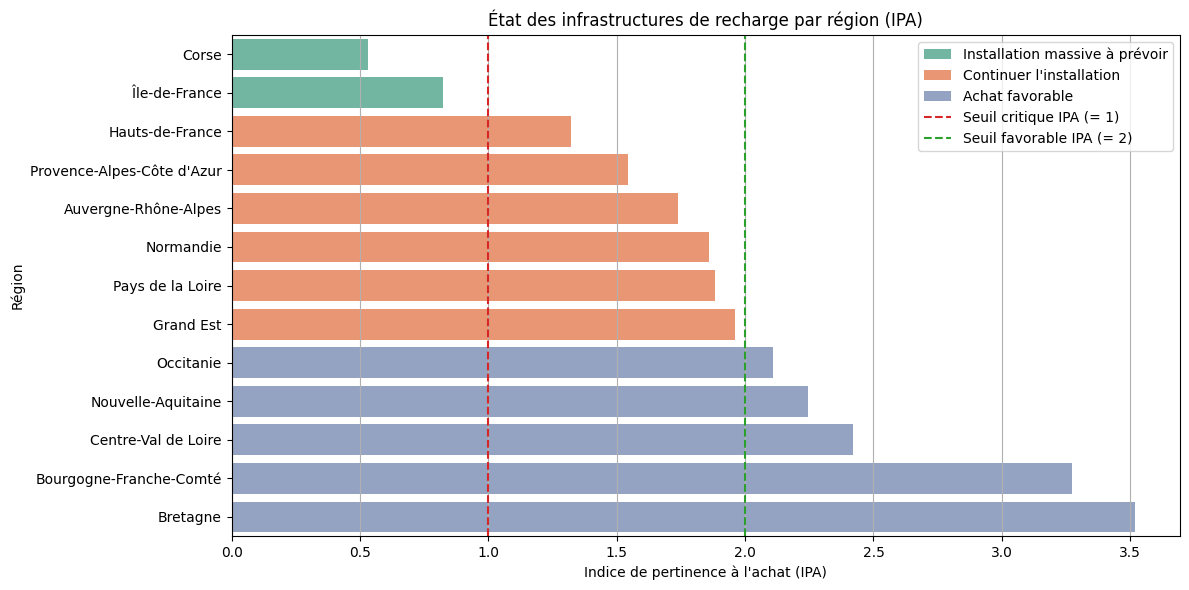

In [5]:
# Création des catégories IPA selon les règles données
def categoriser_IPA(val):
    if val >= 2:
        return "Achat favorable"
    elif val > 1:
        return "Continuer l'installation"
    else:
        return "Installation massive à prévoir"

df_reg["Catégorie_IPA"] = df_reg["IPA"].apply(categoriser_IPA)

# Graphique : Recommandation d’achat par région en fonction de l’IPA
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_reg.sort_values("IPA"),
    x="IPA",
    y="Région",
    hue="Catégorie_IPA",
    dodge=False,
    palette="Set2"
)
plt.axvline(1, color=ROUGE, linestyle="--", label="Seuil critique IPA (= 1)")
plt.axvline(2, color=VERT, linestyle="--", label="Seuil favorable IPA (= 2)")
plt.title("État des infrastructures de recharge par région (IPA)")
plt.xlabel("Indice de pertinence à l'achat (IPA)")
plt.ylabel("Région")
plt.legend()
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()


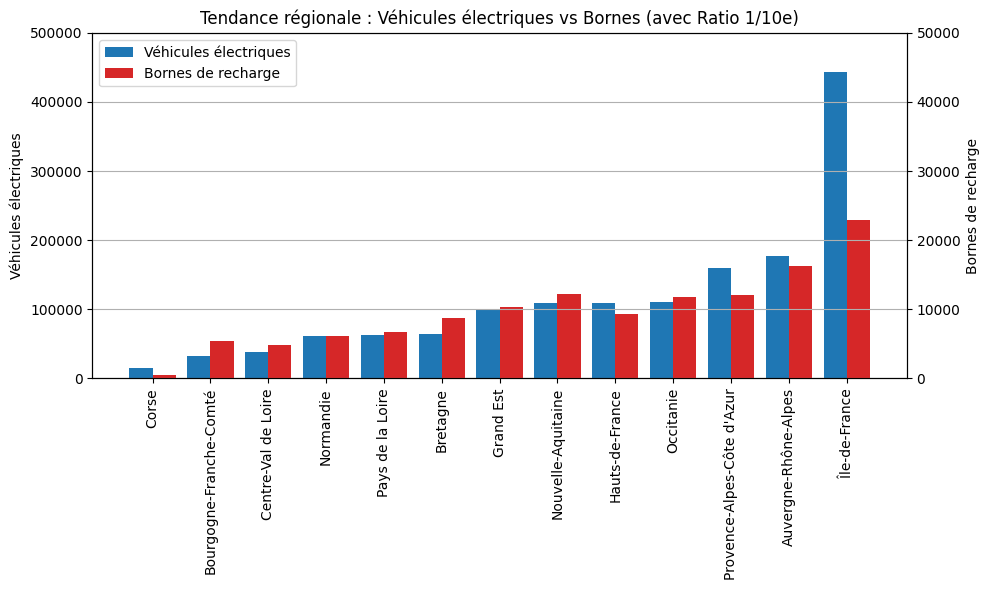

In [6]:
# Trier les données par VE
df_sorted = df_reg.sort_values("VE")

fig, ax1 = plt.subplots(figsize=(10, 6))

# Largeur des barres et positionnement
bar_width = 0.4
x = range(len(df_sorted))

# Axe principal pour VE
ax1.bar([i - bar_width/2 for i in x], df_sorted["VE"], width=bar_width, label="Véhicules électriques", color=BLEU)
ax1.set_ylabel("Véhicules électriques")
ax1.set_ylim(0, 500000)
ax1.set_xticks(x)
ax1.set_xticklabels(df_sorted["Région"], rotation=90)

# Axe secondaire pour Bornes
ax2 = ax1.twinx()
ax2.bar([i + bar_width/2 for i in x], df_sorted["Bornes"], width=bar_width, label="Bornes de recharge", color=ROUGE)
ax2.set_ylabel("Bornes de recharge")
ax2.set_ylim(0, 50000)

# Légendes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
all_lines = lines_1 + lines_2
all_labels = labels_1 + labels_2

ax1.legend(all_lines, all_labels, loc='upper left')


plt.title("Tendance régionale : Véhicules électriques vs Bornes (avec Ratio 1/10e)")
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

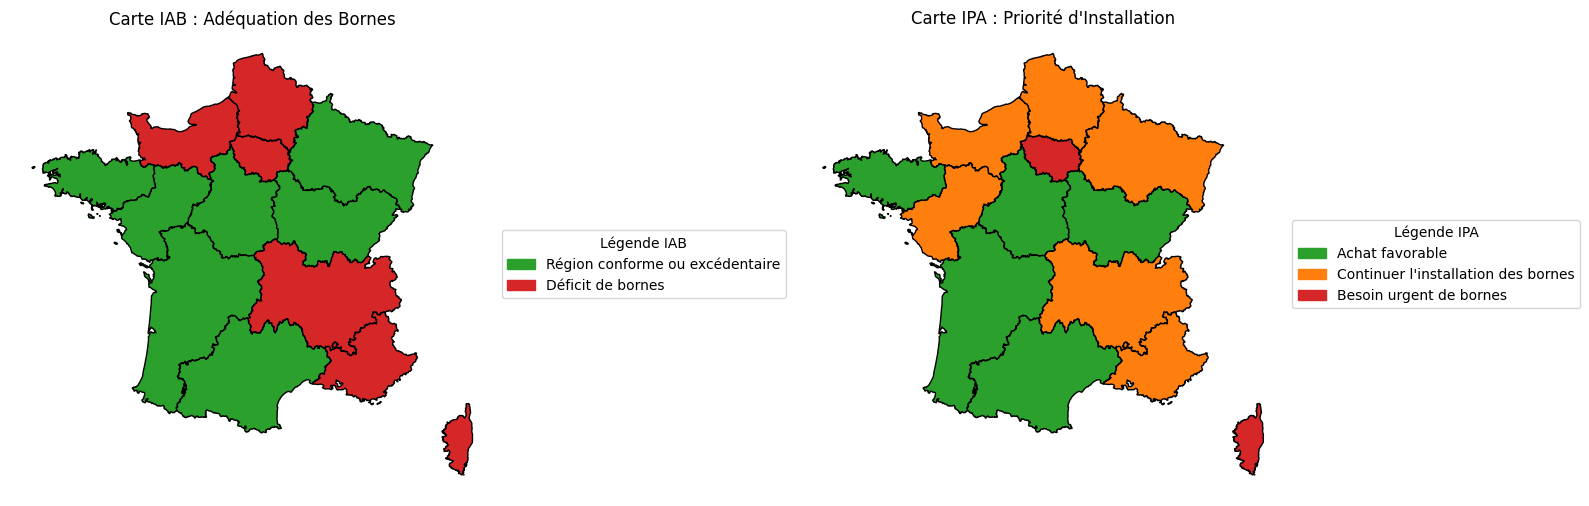

In [7]:
# Chargement des données géographiques
carte = gpd.read_file("regions.geojson")

df_reg["Région"] = df_reg["Région"].str.upper()
carte["nom"] = carte["nom"].str.upper()
carte = carte.merge(df_reg, left_on="nom", right_on="Région")

# Attribuer des couleurs selon IAB
def couleur_iab(val):
    return VERT if val >= 1 else ROUGE

# Attribuer des couleurs selon IPA
def couleur_ipa(val):
    if val >= 2:
        return VERT
    elif val > 1:
        return ORANGE
    else:
        return ROUGE

carte["Couleur_IAB"] = carte["IAB"].apply(couleur_iab)
carte["Couleur_IPA"] = carte["IPA"].apply(couleur_ipa)

# Création des figures
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# -- Carte IAB --
carte.plot(ax=ax[0], color=carte["Couleur_IAB"], edgecolor='black')
ax[0].set_title("Carte IAB : Adéquation des Bornes")
ax[0].axis("off")

# Légende IAB
legend_iab = [
    Patch(color=VERT, label="Région conforme ou excédentaire"),
    Patch(color=ROUGE, label="Déficit de bornes")
]
ax[0].legend(handles=legend_iab, loc="center left", bbox_to_anchor=(1, 0.5), title="Légende IAB")

# -- Carte IPA --
carte.plot(ax=ax[1], color=carte["Couleur_IPA"], edgecolor='black')
ax[1].set_title("Carte IPA : Priorité d'Installation")
ax[1].axis("off")

# Légende IPA
legend_ipa = [
    Patch(color=VERT, label="Achat favorable"),
    Patch(color=ORANGE, label="Continuer l'installation des bornes"),
    Patch(color=ROUGE, label="Besoin urgent de bornes")
]
ax[1].legend(handles=legend_ipa, loc="center left", bbox_to_anchor=(1, 0.5), title="Légende IPA")

plt.tight_layout()
plt.show()


### 🧠 Résumé stratégique par région :

#### 🟢 Régions exemplaires (IAB ≥ 1 & IPA ≥ 2)  
**Bourgogne-Franche-Comté**, **Bretagne**, **Centre-Val de Loire**, **Nouvelle-Aquitaine**, **Occitanie**  
→ Achat de véhicules électriques encouragé, l’infrastructure suit bien.

---

#### 🟠 Régions équilibrées mais sous surveillance  
**Pays de la Loire**, **Normandie**, **Grand Est**, **Auvergne-Rhône-Alpes**, **Hauts-de-France**  
→ Continuer les installations pour accompagner la croissance de la mobilité électrique.

---

#### 🔴 Régions en difficulté  
**Provence-Alpes-Côte d’Azur (PACA)**  
→ IAB et IPA insuffisants : accélérer l'installation de bornes.  

**Île-de-France**  
→ Forte demande et très faible couverture : situation critique à traiter en priorité.

**Corse**  
→ Enclavement et retard technologique net : priorité absolue à l’équipement.


# Diagnostique par département

Notez que ce dataframe a été construite à partir de ces données :
- [Fichier consolidé des Bornes de Recharge pour Véhicules Électriques](https://defis.data.gouv.fr/datasets/5448d3e0c751df01f85d0572) en récupérant, à l'aide de la colonne "adresse_station" : son Code INSEE, nom du commune, nom du département et nom du région.
  → Pour cela, nous avons utilisé un API, par exemple pour l'adresse "51 Rue du Cardinal Lemoine" : https://api-adresse.data.gouv.fr/search/?q=51%20Rue%20du%20Cardinal%20Lemoine
- [Voitures particulières immatriculées par commune et par type de recharge](https://defis.data.gouv.fr/datasets/628310650b8550478a9ddd2d)
- [Communes et villes de France](https://www.data.gouv.fr/fr/datasets/communes-et-villes-de-france-en-csv-excel-json-parquet-et-feather/) sur l'année 2024

In [8]:
df_dep = pd.read_csv("df_diagnostic_departement.csv")

## Indice d’adéquation des bornes (IAB)
$$
\text{IAB} = \frac{\text{Nombre de bornes}}{\left(\frac{\text{Nombre de véhicules électriques}}{10}\right)}
$$
- Si IAB ≥ 1 : Le département est conforme ou excédentaire
- Si IAB < 1 : Le département a un déficit de bornes
## Indice de Pertinence pour l’Achat (IPA)
$$
\text{IPA} = \frac{\text{Nombre de bornes}}{\text{Population (en milliers)}} \times \text{Indice d’adéquation des bornes (IAB)}
$$
- Si IPA ≥ 2 : Il est favorable d'acheter un véhicule électrique dans ce département
- Si IPA > 1 : Le département possède environ assez de borne pour assurer la recharge de ses véhicule, mais avec leur population la tendance pourrait s'inverser donc continuer l'installation de bornes
- Si IPA ≤ 1 : le département doit prévoir une installation massive de borne, on est très loin de pouvoir assurer la recharge de tous les utilisateurs

In [9]:
df_dep['IPA'] = (df_dep['Nombre de bornes'] / (df_dep['population'] / 1000)) * df_dep['IAB']

## Réalisation de graphiques pour l'analyse par régions

In [10]:
df_dep.columns = ['Région', 'Département', 'VE', 'Bornes', 'Population', 'IAB', 'IPA']
pd.set_option('display.max_rows', 40)
df_dep

,Région,Département,VE,Bornes,Population,IAB,IPA
0,Auvergne-Rhône-Alpes,Ain,10527,819,657417,0.777999,0.969220
1,Auvergne-Rhône-Alpes,Allier,3098,866,335628,2.795352,7.212672
2,Auvergne-Rhône-Alpes,Ardèche,5401,723,329325,1.338641,2.938852
3,Auvergne-Rhône-Alpes,Cantal,1616,254,144379,1.571782,2.765171
4,Auvergne-Rhône-Alpes,Drôme,12730,1632,517709,1.282011,4.041347
...,...,...,...,...,...,...,...
91,Île-de-France,Seine-Saint-Denis,39404,2005,1655422,0.508832,0.616282
92,Île-de-France,Seine-et-Marne,31903,3515,1428636,1.101777,2.710800
93,Île-de-France,Val-d'Oise,30220,1697,1251804,0.561549,0.761260
94,Île-de-France,Val-de-Marne,29963,2052,1407972,0.684845,0.998103


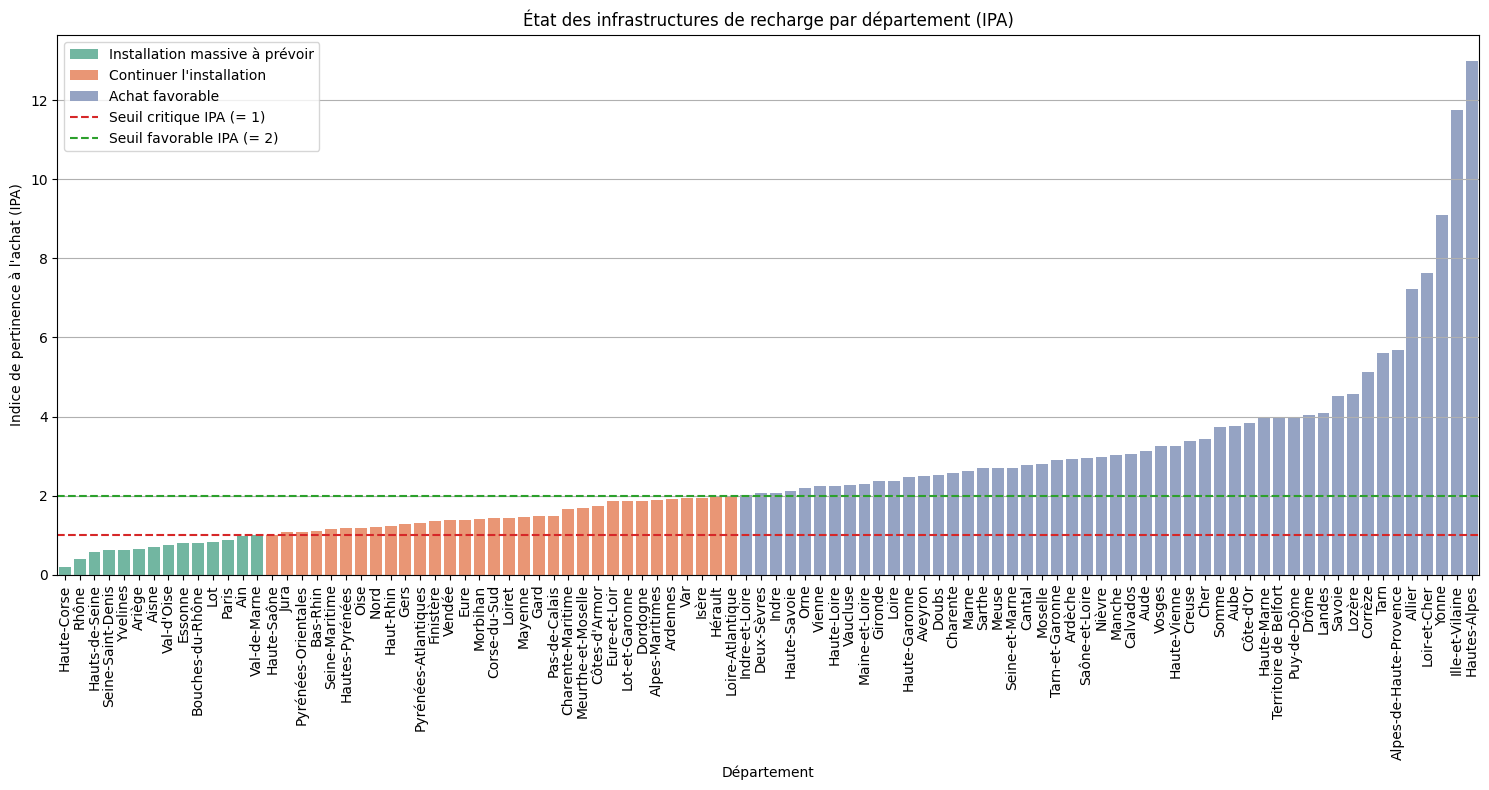

In [11]:
df_dep["Catégorie_IPA"] = df_dep["IPA"].apply(categoriser_IPA)

# Graphique vertical
plt.figure(figsize=(15, 8))  # Hauteur plus grande pour l'affichage vertical

sns.barplot(
    data=df_dep.sort_values("IPA"),
    x="Département",
    y="IPA",
    hue="Catégorie_IPA",
    dodge=False,
    palette="Set2"
)

# Lignes de seuil horizontales (au lieu de verticales)
plt.axhline(1, color=ROUGE, linestyle="--", label="Seuil critique IPA (= 1)")
plt.axhline(2, color=VERT, linestyle="--", label="Seuil favorable IPA (= 2)")

plt.title("État des infrastructures de recharge par département (IPA)")
plt.xlabel("Département")
plt.ylabel("Indice de pertinence à l'achat (IPA)")

plt.xticks(rotation=90)
plt.legend()
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


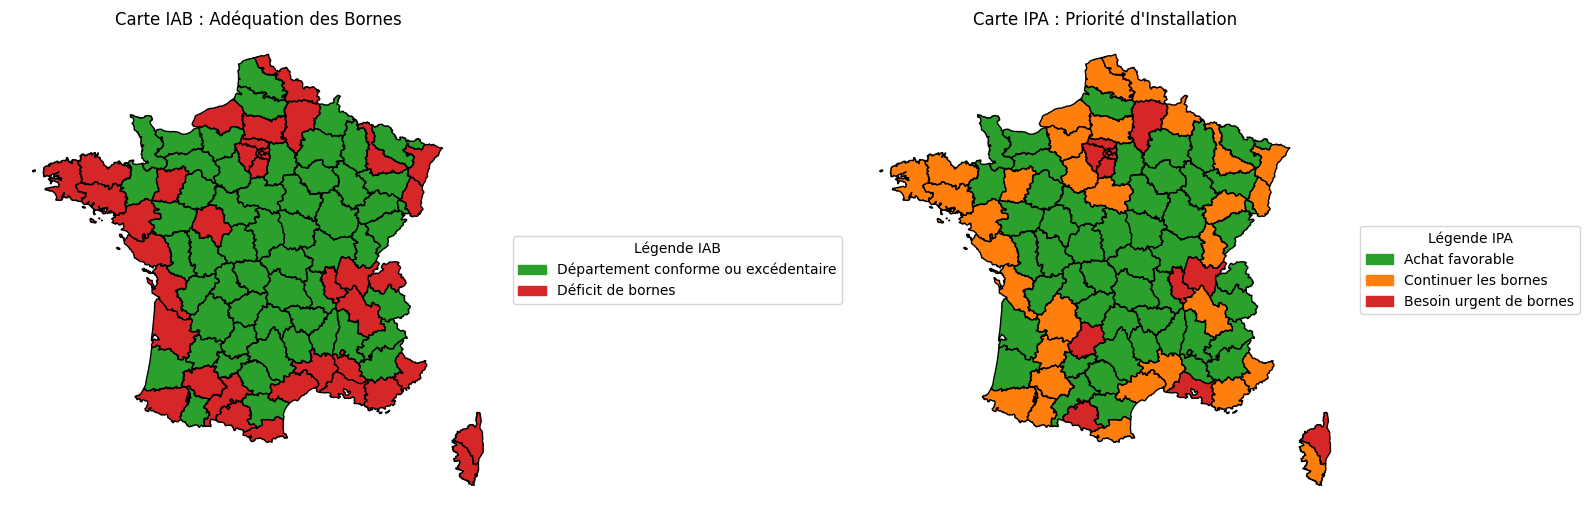

In [12]:
# Chargement des données géographiques
carte = gpd.read_file("departements.geojson")

df_dep["Département"] = df_dep["Département"].str.upper()
carte["nom"] = carte["nom"].str.upper()
carte = carte.merge(df_dep, left_on="nom", right_on="Département")

# Attribuer des couleurs selon IAB
def couleur_iab(val):
    return VERT if val >= 1 else ROUGE

# Attribuer des couleurs selon IPAs
def couleur_ipa(val):
    if val >= 2:
        return VERT
    elif val > 1:
        return ORANGE
    else:
        return ROUGE

carte["Couleur_IAB"] = carte["IAB"].apply(couleur_iab)
carte["Couleur_IPA"] = carte["IPA"].apply(couleur_ipa)

# Création des figures
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# -- Carte IAB --
carte.plot(ax=ax[0], color=carte["Couleur_IAB"], edgecolor='black')
ax[0].set_title("Carte IAB : Adéquation des Bornes")
ax[0].axis("off")

# Légende IAB
legend_iab = [
    Patch(color=VERT, label="Département conforme ou excédentaire"),
    Patch(color=ROUGE, label="Déficit de bornes")
]
ax[0].legend(handles=legend_iab, loc="center left", bbox_to_anchor=(1, 0.5), title="Légende IAB")

# -- Carte IPA --
carte.plot(ax=ax[1], color=carte["Couleur_IPA"], edgecolor='black')
ax[1].set_title("Carte IPA : Priorité d'Installation")
ax[1].axis("off")

# Légende IPA
legend_ipa = [
    Patch(color=VERT, label="Achat favorable"),
    Patch(color=ORANGE, label="Continuer les bornes"),
    Patch(color=ROUGE, label="Besoin urgent de bornes")
]
ax[1].legend(handles=legend_ipa, loc="center left", bbox_to_anchor=(1, 0.5), title="Légende IPA")

plt.tight_layout()
plt.show()


### 🧠 Résumé stratégique par département :

#### 🟢 Départements exemplaires (IAB ≥ 1 et IPA ≥ 2)  
→ Forte adéquation entre les véhicules électriques et les infrastructures.  
**Exemples** :  
- **Allier** (2.80 IAB / 7.21 IPA)  
- **Yonne** (2.68 / 9.10)  
- **Loir-et-Cher** (2.18 / 7.63)  
- **Hautes-Alpes** (2.67 / 13.00)  
- **Lozère** (2.15 / 4.58)  
- **Tarn** (1.75 / 5.61)  
- **Corrèze** (2.19 / 5.13)  

---

#### 🟠 Départements équilibrés mais à surveiller (IAB ≥ 1 et 1 ≤ IPA < 2)  
→ L’équipement suit la tendance mais la croissance de l’usage peut rapidement créer un décalage.  
**Exemples** :  
- **Sarthe** (2.18 / 2.69)  
- **Nièvre** (1.76 / 2.97)  
- **Moselle** (1.28 / 2.81)  
- **Gironde** (0.99 / 2.37)  
- **Indre-et-Loire** (0.91 / 2.01)  
- **Var** (0.78 / 1.95)

---

#### 🔴 Départements à risque ou en retard (IAB < 1 ou IPA < 1)  
→ Infrastructures insuffisantes pour répondre à la demande actuelle ou future.  
**Exemples** :  
- **Rhône** (0.42 / 0.39)  
- **Haute-Corse** (0.19 / 0.21)  
- **Paris** (0.66 / 0.89)  
- **Hauts-de-Seine** (0.30 / 0.59)  
- **Seine-Saint-Denis** (0.51 / 0.62)  
- **Yvelines** (0.33 / 0.62)  
- **Ain** (0.78 / 0.97)

---

#### ⚠️ Cas particuliers à fort contraste  
→ Certains départements ont un bon IAB mais un IPA faible ou inversement. Cela traduit un déséquilibre structurel.  
**Exemples** :  
- **Essonne** (0.53 / 0.80) : faible couverture malgré forte adoption.  
- **Charente-Maritime** (0.91 / 1.66) : sur le fil, attention à la dynamique de croissance.  
- **Ariège** (0.99 / 0.64) : l’infrastructure est là, mais la dynamique est faible.
